# Nonlinear Regression with Pytorch Modules - Experiments

Make sure you understand the code below and run some experiments.  We've changed the underlying ground truth function to make it a bit more complicated

1.  Increase the number of observations to 500 and change batch size to 50.  How does it work?

2.  Increase the number of neurons in the hidden layer.  Can you get a better fit?  Try 10, 20, 40.  What seems to be a good value.  Also for each hidden layer size try a couple of different PyTorch random number seeds when you instantiate the model.  Are the results sensitive to the seed?

3.  Add another hidden layer with a ReLU activation function.  It can be the same size as the first hidden layer.  Can you get better fits to the data and ground truth curve?

4.  Try changing the activation for the second hidden layer to a sigmoid function (`nn.Sigmoid`).  What does this do to the quality of your fit to to ground truth?

5.  With your final model try some different batch sizes.  One batch size should be the full dataset.  Try a small batch size too, but if you decrease it too far Python will be slow because for loops are slow.



## Packages & global parameters



We will need to import the `torch` package for the main functionality.
In order to have a convenient, we will use PyTorch's `DataLoader` and `Dataset` in order to feed our training data to the model.



In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# set the default theme for Seaborn plots
sns.set_theme()

## True model & training data



The &ldquo;true model&rdquo; is a constructed non-linear function $y = f(x)$.
Here is its definition and a plot to show what the &ldquo;ground truth&rdquo; looks like.



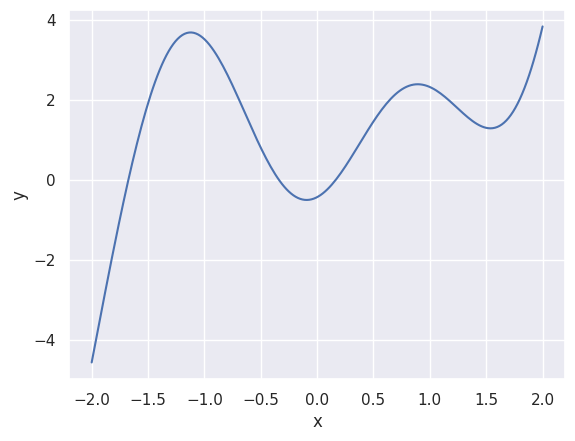

In [24]:
##################################################
## ground-truth model
##################################################

def goalFun(x):
    return .25*(4 * x**3 - 7 * x + 5 ) + 2*np.sin(3*x-1)

# create linear sequence (x) and apply goalFun (y)
x = np.linspace(start = -2, stop =2, num = 200)
y = goalFun(x)

# plot the function
d = pd.DataFrame({'x' : x, 'y' : y})
sns.lineplot(data = d, x = 'x', y = 'y')
plt.show()

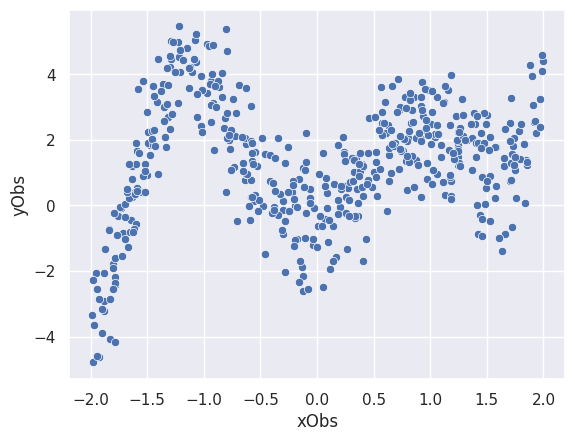

In [25]:
##################################################
## generate training data (with noise)
##################################################

nObs = 500 # number of observations

torch.manual_seed(43) # reproducibility, remove to experiment

# get noise around y observations
yNormal = torch.distributions.Normal(loc=0.0, scale=1.0) # normal mean 0, std 1
yNoise  = yNormal.sample([nObs])

# get observations
xObs = 4*torch.rand([nObs])-2    # uniform from [-2,2]
yObs = goalFun(xObs) + yNoise

# plot the data
d = pd.DataFrame({'xObs' : xObs, 'yObs' : yObs})
sns.scatterplot(data = d, x = 'xObs', y = 'yObs')
plt.show()

## Build the dataset



In [28]:
##################################################
## representing train data as a Dataset object
##################################################

class nonLinearRegressionData(Dataset):
    '''
    Custom 'Dataset' object for our regression data.
    Must implement these functions: __init__, __len__, and __getitem__.
    '''

    def __init__(self, xObs, yObs):
        # we're passing in one-dimensional tensors, but they should be
        # two-dimensional "column vectors"
        self.xObs = torch.reshape(xObs, (len(xObs), 1))
        self.yObs = torch.reshape(yObs, (len(yObs), 1))

    def __len__(self):
        return(len(self.xObs))

    def __getitem__(self, idx):
        return(self.xObs[idx], self.yObs[idx])

# instantiate Dataset object for current training data
dset = nonLinearRegressionData(xObs, yObs)

## Define the model



In [27]:
##################################################
## network dimension parameters
##################################################

nInput  = 1
nHidden = 3
nOutput = 1

##################################################
## Use nn.Sequential to define all the layers
##################################################

class NonlinearRegression(nn.Module):
    '''
    Multi-layer perceptron for non-linear regression.
    '''
    def __init__(self, nInput, nHidden, nOutput):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(nInput, nHidden),
            nn.ReLU(),
            nn.Linear(nHidden, nOutput),
        )

    def forward(self, x):
        return(self.layers(x))

model = NonlinearRegression(nInput, nHidden, nOutput)

## Train the model and visualize the result



Average loss per data after epoch 100 is 1.199
Average loss per data after epoch 200 is 1.157
Average loss per data after epoch 300 is 1.163
Average loss per data after epoch 400 is 1.156
Average loss per data after epoch 500 is 1.153
Training process has finished.


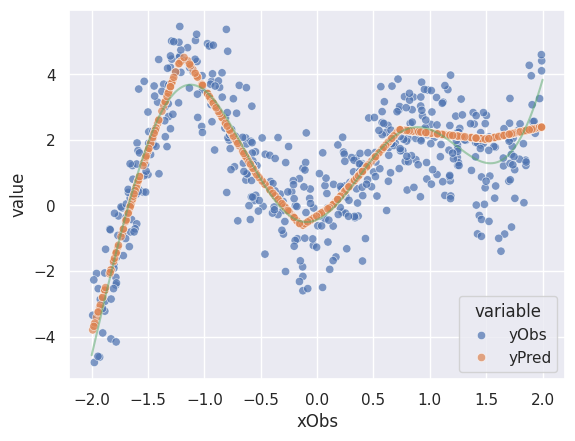

In [39]:
##################################################
## training the model
##################################################

nTrainSteps = 500
outputInterval = 100
learningRate = 1e-2
batchSize = 50

# Create a new instance of the model to randomize the weights each time
torch.manual_seed(44) #
model = NonlinearRegression(nInput, nHidden, nOutput)

# Make new instance of dataloader with batchSize
train_dataloader = DataLoader(dset, batch_size=batchSize, shuffle=True)


# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

# Run the training loop
for epoch in range(0, nTrainSteps):

  # Set current loss value
  current_loss = 0.0
  num_batches = 0

  # Iterate over the DataLoader for training data
  for i, data in enumerate(train_dataloader):
    # Get inputs
    inputs, targets = data
    # Zero the gradients
    optimizer.zero_grad()
    # Perform forward pass (make sure to supply the input in the right way)
    outputs = model(inputs)
    # Compute loss
    loss = loss_function(outputs, targets)
    # Perform backward pass
    loss.backward()
    # Perform optimization
    optimizer.step()
    # Print statistics
    current_loss += loss.item()
    num_batches += 1

  if (epoch + 1) % outputInterval == 0:
      print(f'Average loss per data after epoch {epoch+1} is {current_loss/num_batches:.3f}')

# Process is complete.
print('Training process has finished.')

yPred = np.array([model.forward(torch.tensor([o])).detach().numpy() for o in xObs]).flatten()

# plot the data
d = pd.DataFrame({'xObs' : xObs.detach().numpy(),
                  'yObs' : yObs.detach().numpy(),
                  'yPred': yPred})
dWide = pd.melt(d, id_vars = 'xObs', value_vars= ['yObs', 'yPred'])
sns.scatterplot(data = dWide, x = 'xObs', y = 'value', hue = 'variable', alpha = 0.7)
x = np.linspace(start = -2, stop =2, num = 200)
y = goalFun(x)
plt.plot(x,y, color='g', alpha = 0.5)
plt.show()